# Downloading and Peparing the data

In [178]:
#Importing the packaged

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from multiprocessing import Pool
import time
import sys
import urllib.request
import json

In [179]:
import networkx as nx
from networkx.algorithms import bipartite

In [180]:
# Creating a function that uses mapbox api to get NYC neighborhood name given our crime GPS coordinate
# Code adapted from Javascrip code obtained from Stack Overflow: 
# https://stackoverflow.com/questions/42583857/api-to-convert-lat-lon-to-nyc-neighborhood

access_token = '?access_token=pk.eyJ1IjoibWFwYm94IiwiYSI6ImNpejY4NXVycTA2emYycXBndHRqcmZ3N3gifQ.rJcFIG214AriISLbB6B5aw'
urlInit = 'https://api.mapbox.com/geocoding/v5/'
mode = 'mapbox.places/'
var_type = '&types=neighborhood'

def getNeighborhood(lat,lon):
    lonlat = str(lon) + '%2C' + str(lat) + '.json'
    url = urlInit + mode + lonlat + access_token + var_type
    with urllib.request.urlopen(url) as response:
        html = response.read().decode('utf-8')
    json_obj = json.loads(html)
    return json_obj['features'][0]['text']
    

In [181]:
# Loading NYC complaints from January 1st 2018 to November 1st 2018

data2018 = np.array(list(csv.reader(open("/Users/jennifervial/Downloads/Project Network/NYPD_Complaint_Data_Current__Year_To_Date_.csv", "r"), delimiter=",")))

In [ ]:
# Obtain the neighborhood information on all our crime data and saving it
# !! Careful !! Takes 2 hours to run

F = open("Longitude_Latitude_Neighborhood.csv", 'w')
F.write("Longitude,Latitude,Neighborhood\n")
for i in data2018[1:]:
    lon = i[-2]
    lat = i[-3]
    try:
        nei = getNeighborhood(lat,lon)
        line = str(lon) +','+ str(lat) +','+ str(nei) +'\n'
        F.write(line)
    except:
        line = str(lon) +','+ str(lat) +','+ "no neihborhood" +'\n'
        F.write(line)
F.close()

In [182]:
# Loading the data obtained and saved in the previous cell.

neihborhood = np.array(list(csv.reader(open("/Users/jennifervial/Downloads/Project Network/Longitude_Latitude_Neighborhood.csv", "r"), delimiter=",")))

In [183]:
# Loading the data merged in excel of the neighborhoods of each crime, with the type of crime.

dataGraph = np.array(list(csv.reader(open("/Users/jennifervial/Downloads/Project Network/Data-for-graph.csv", "r"), delimiter=",")))

In [184]:
# Same as dataGraph, but with the neighborhoods ordred by borough, and the crime ordered by crime types.

dataGraph2 = np.array(list(csv.reader(open("/Users/jennifervial/Downloads/Project Network/Data-for-graph2.csv", "r"), delimiter=",")))

In [185]:
dataGraph3 = np.array(list(csv.reader(open("/Users/jennifervial/Downloads/Project Network/Data-for-graph3.csv", "r"), delimiter=",")))

### Creating the Bipartite Graph

This part was a trial, it holds some insights in our data but in the end was not used for our final results.
It can be skipped.

In [186]:
# Creating a bipartite graph with the type of crimes as one type of nodes, and neighborhood as the other type.

G = nx.Graph()
# Adding attribute "bipartite" to differentiate two different classes in the bipartite garph
G.add_nodes_from(dataGraph[1:,2], bipartite=0)
G.add_nodes_from(dataGraph[1:,3], bipartite=1)

In [187]:
# Same as previous graph, but with the nodes ordered for easier visualisation.

G2 = nx.Graph()
G2.add_nodes_from(dataGraph2[1:,2], bipartite=0)
G2.add_nodes_from(dataGraph3[1:,3], bipartite=1)

In [188]:
G2.nodes

NodeView(('Longwood', 'Soundview', 'South Bronx', 'High Bridge', 'University Heights', 'Williamsbridge', 'Tremont', 'Parkchester', 'Morris Heights', 'Morris Park', 'Concourse', 'Fordham', 'Van Nest', 'Norwood', 'Bedford Park', 'Wakefield', 'East Tremont', 'Melrose', 'Mott Haven', 'West Farms', 'Eastchester', 'Co-op City', 'Pelham Bay', 'Throggs Neck', 'Kingsbridge', 'Hunts Point', 'City Island', 'Pelham Gardens', 'Unionport', 'Belmont', 'Port Morris', 'Baychester', 'Marble Hill', 'Castle Hill', 'Fieldston', 'Clason Point', 'Country Club', 'Rikers Island', 'North Riverdale', 'Westchester Heights', 'Woodlawn', 'Riverdale', 'no neihborhood BRONX', 'Spuyten Duyvil', 'Washington Heights', 'Van Cortlandt Park', 'Pelham Bay Park', 'Bronx Park', 'East New York', 'Brownsville', 'Bedford Stuyvesant', 'East Harlem', 'Crown Heights', 'Canarsie', 'Greenpoint', 'Flatbush', 'Williamsburg', 'Sheepshead Bay', 'Bath Beach', 'Flatlands', 'Bushwick', 'East Flatbush', 'Greenwood', 'Fort Greene', 'Kensingto

In [189]:
edgelist = [ (i[2],i[3]) for i in dataGraph2[1:]]

In [191]:
G2.add_edges_from(edgelist)

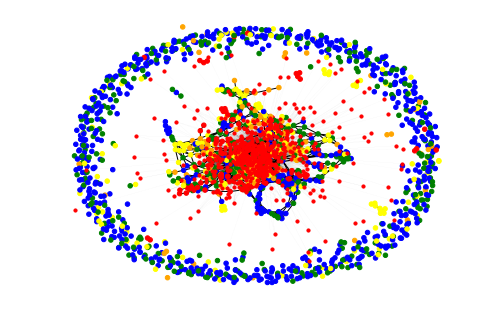

In [192]:
# Premilinary visulaisation of bipartite graph.

nx.draw(G2, node_size=10, width=0.01)
plt.show()

In [193]:
print(nx.is_connected(G2))

True


In [194]:
nx.is_bipartite(G)

True

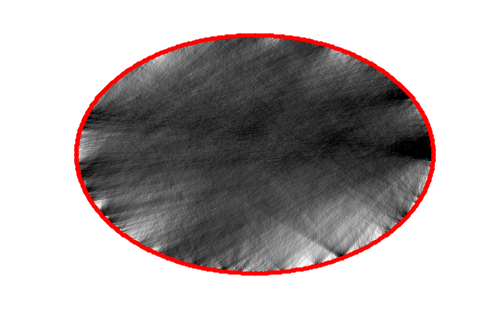

In [195]:
# Other visualisation of our Graph

from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
nx.draw_circular(G2, node_size=10, width=0.01)
#plt.savefig('network_all_intial_order_line_width_0.01_circular.PNG', dpi = 300)
plt.show()

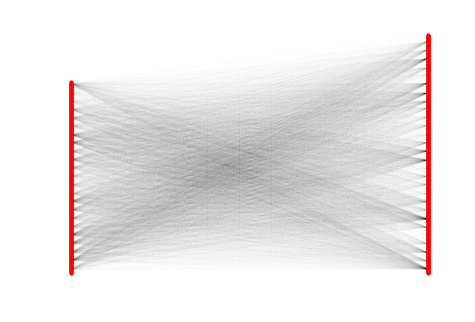

In [196]:
# Better visualisation for our bipartite Graph.
# Are nodes are ordered by type of borough on the left, and type of crime on the right.
# However the nodes with the highest degree seems to be evenly distibuted in each category.

X, Y = bipartite.sets(G2)
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(X) ) # put nodes from X at x=1
pos.update( (n, (2, i)) for i, n in enumerate(Y) ) # put nodes from Y at x=2
nx.draw(G2, pos=pos, node_size=10, width=0.001)
#plt.savefig("network_all_intial_order_line_width_0.001_paralell.PNG", dpi = 300)
plt.show()

### Neighborhood proximity graph

Creating a graph where the nodes are the neighborhoods, and the edges are made with the 5 neareast neighborhoods.
The five nearest neighborhood were choosen instead of the actual neighborhood touching a given neighborhood because we were not able to find a dataset providing this information. The only way would have been to create it manually from an online map, which would have lead to potential human errors.

We choose the five closest neighborhood because when looking at a map, we noticed that on average a neighborhood in NYC touches 5 other neighborhoods.

In [197]:
# Uploading a file which is the dataGraph data which have been grouped by neighborhoods, 
# so that the GPS coordinate of a neighborhood are the average of the GPS coordinate of the crimes that
# occured in that neighborhood

data = np.array(list(csv.reader(open("/Users/jennifervial/Downloads/Project Network/File for J2.csv", "r"), delimiter=",")))

In [198]:
# Creating the edge list of the 5 closest neighborhood of a given neighborhood

edges = []
data = data[1:]
for j in range(len(data)):
    distances = []
    for i in range(len(data)):
        distances.append(abs(float(data[j][0])-float(data[i][0])) + abs(float(data[j][1])-float(data[i][1])))
    sorted_indices = np.argsort(distances)
    edges.append((data[j][2],data[sorted_indices[1]][2]))
    edges.append((data[j][2],data[sorted_indices[2]][2]))
    edges.append((data[j][2],data[sorted_indices[3]][2]))
    edges.append((data[j][2],data[sorted_indices[4]][2]))
    edges.append((data[j][2],data[sorted_indices[5]][2]))

In [199]:
# Transforming our edge list in a panda dataframe

dfedges = pd.DataFrame(edges, columns=['N1', 'N2'])

In [200]:
# Loading the data for graph mentioned above, and transforming it into a panda dataframe

datapanda = pd.read_csv("/Users/jennifervial/Downloads/Project Network/Data-for-graph.csv",delimiter =",")

In [201]:
# Getting rid of the crimes without GPS coordinates (negligeable: 0.001%)

datapanda= datapanda[datapanda.Neighborhood != 'no neihborhood QUEENS']
datapanda= datapanda[datapanda.Neighborhood !='no neihborhood MANHATTAN']
datapanda= datapanda[datapanda.Neighborhood !='no neihborhood BRONX']
datapanda= datapanda[datapanda.Neighborhood !='no neihborhood STATEN ISLAND']
datapanda= datapanda[datapanda.Neighborhood !='no neihborhood BROOKLYN']

In [202]:
datapanda.head()

,Longitude,Latitude,Neighborhood,PD_CD,PD_DESC,BORO_NM
0,-73.769745,40.683786,St. Albans,637.0,"HARASSMENT,SUBD 1,CIVILIAN",QUEENS
2,-73.953117,40.726965,Greenpoint,478.0,"THEFT OF SERVICES, UNCLASSIFIE",BROOKLYN
3,-73.897849,40.824519,Longwood,567.0,"MARIJUANA, POSSESSION 4 & 5",BRONX
4,-73.867003,40.822552,Soundview,114.0,OBSTR BREATH/CIRCUL,BRONX
5,-73.891225,40.712362,Maspeth,905.0,"INTOXICATED DRIVING,ALCOHOL",QUEENS


In [203]:
datapanda.count()

Longitude       228636
Latitude        228636
Neighborhood    228636
PD_CD           228488
PD_DESC         228488
BORO_NM         228486
dtype: int64

In [204]:
# Grouping our dataframe per neighborhood to obtain the number of crimes per neighborhood through our time period

nbcrimenei = datapanda.groupby('Neighborhood').count()

In [205]:
# Dropping unnecessary columns

nbcrimenei = nbcrimenei.drop(columns = ["Latitude", "PD_CD", "PD_DESC", "BORO_NM"])

In [206]:
# The column Longitude actually is now the number of crime per neighborhood

nbcrimenei.reset_index(level=0, inplace=True)
nbcrimenei.head()

,Neighborhood,Longitude
0,Annadale,78
1,Arden Heights,105
2,Arrochar,239
3,Arverne,320
4,Astoria,3550


In [207]:
# Sorting the neighborhood by order of crime rate for visualisation purpose.

m = nbcrimenei.sort_values(by = 'Longitude')
m.head()

,Neighborhood,Longitude
93,Fresh Kills,2
126,Jacob Riis Park,2
161,Navy Yard,2
211,Roxbury,3
135,La Guardia Airport,4


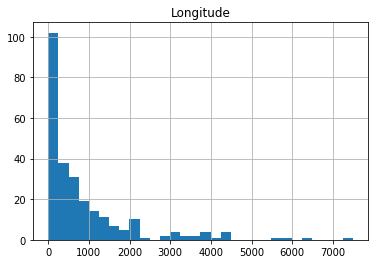

In [208]:
# Plotting an histogram

nbcrimenei.hist(bins = 30)
plt.show()

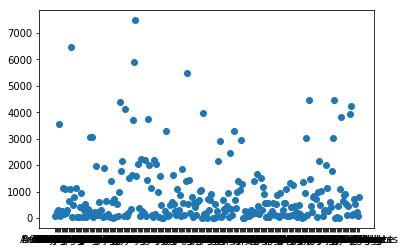

In [209]:
# Plotting the number of crimes per neighborhood
x = list(m['Neighborhood'])
y = list(m['Longitude'])
plt.scatter(x, y)
plt.show()

# We identify 5 different group from this graph

In [210]:
# Renaming our columns

nbcrimenei = nbcrimenei.rename(index=str, columns={"index": "index", "Neighborhood": "Neighborhood", "Longitude": "NB Crime"})

In [211]:
# Assigning the crime group to each neighborhood from 5(extremely dangerous) to 1(totally safe)

# Create a list to store the data
crime_sc = []

# For each row in the column,
for row in nbcrimenei['NB Crime']:
    # if more than a value,
    if row > 5000:
        # Append a crime score
        crime_sc.append(5)
    # else, if more than a value,
    elif row > 2500:
        # Append a crime score
        crime_sc.append(4)
    # else, if more than a value,
    elif row > 1000:
        # Append a crime score
        crime_sc.append(3)
    # else, if more than a value,
    elif row > 250:
        # Append a crime score
        crime_sc.append(2)
    # else, if more than a value,
    else:
        # Append a crime score
        crime_sc.append(1)
        
# Create a column from the list
nbcrimenei['Crime Score'] = crime_sc

In [212]:
nbcrimenei.head()

,Neighborhood,NB Crime,Crime Score
0,Annadale,78,1
1,Arden Heights,105,1
2,Arrochar,239,1
3,Arverne,320,2
4,Astoria,3550,4


In [213]:
#Saving the node list ordered in alphabetical order

F = open("nodes.csv", 'w')
for r in range(len(nbcrimenei["Neighborhood"])):
    line = str(nbcrimenei["Neighborhood"][r]) + "\n"
    F.write(line)
F.close()

In [214]:
# Creating a color maping of the crime levels of neighborhood (in alphabetical order) for visualisation

color_map = []
for node in nbcrimenei["Crime Score"] :
    if node == 5:
        color_map.append('red')
    elif node == 4:
        color_map.append('orange')
    elif node == 3:
        color_map.append('yellow')
    elif node == 2:
        color_map.append('green')
    else: color_map.append('blue')  

In [215]:
# Saving our color_map

F = open("color_map.csv", 'w')
for r in color_map:
    line = str(r) + "\n"
    F.write(line)
F.close()

In [216]:
# Finding out how many neighborhood per crime levels

nbcrimenei.groupby('Crime Score').count()

,Neighborhood,NB Crime
Crime Score,,
1,102,102
2,88,88
3,48,48
4,19,19
5,4,4


In [217]:
#crime_sc = nbcrimenei.drop(columns = ["index"])
crime_sc = nbcrimenei

In [218]:
# Merging our edge list of close neighbors with our crime rate for edges selection later on

dfedges = dfedges.merge(crime_sc, left_on='N1', right_on='Neighborhood', how = 'left', suffixes=('', '_N1'), copy='True')

dfedges = dfedges.merge(crime_sc, left_on='N2', right_on='Neighborhood', how = 'left', suffixes=('', '_N2'),copy='True')

In [219]:
# The new dataframe

dfedges.head()

,N1,N2,Neighborhood,NB Crime,Crime Score,Neighborhood_N2,NB Crime_N2,Crime Score_N2
0,Longwood,Hunts Point,Longwood,2166.0,3.0,Hunts Point,664.0,2.0
1,Longwood,South Bronx,Longwood,2166.0,3.0,South Bronx,4450.0,4.0
2,Longwood,Melrose,Longwood,2166.0,3.0,Melrose,2459.0,3.0
3,Longwood,Soundview,Longwood,2166.0,3.0,Soundview,3010.0,4.0
4,Longwood,East Tremont,Longwood,2166.0,3.0,East Tremont,1580.0,3.0


In [220]:
# Finding out the difference in crime level between two close neighborhood

dfedges["Edge score"] = dfedges["Crime Score"] - dfedges["Crime Score_N2"]

dfedges["Edge score"] = dfedges["Edge score"].abs()

In [221]:
dfedges.shape

(1310, 9)

In [222]:
len(edges)

1310

In [223]:
dfedges.head()

,N1,N2,Neighborhood,NB Crime,Crime Score,Neighborhood_N2,NB Crime_N2,Crime Score_N2,Edge score
0,Longwood,Hunts Point,Longwood,2166.0,3.0,Hunts Point,664.0,2.0,1.0
1,Longwood,South Bronx,Longwood,2166.0,3.0,South Bronx,4450.0,4.0,1.0
2,Longwood,Melrose,Longwood,2166.0,3.0,Melrose,2459.0,3.0,0.0
3,Longwood,Soundview,Longwood,2166.0,3.0,Soundview,3010.0,4.0,1.0
4,Longwood,East Tremont,Longwood,2166.0,3.0,East Tremont,1580.0,3.0,0.0


We now create different edges lists with the information put together

In [224]:
# Edges for close neighborhood if their crime level difference is 0 or 1

newedges = []
for i in range(dfedges.shape[0]):
    if dfedges.loc[i, "Edge score"] < 2:
        newedges.append((dfedges.loc[i, "N1"],dfedges.loc[i, "N2"]))
        

In [49]:
# Edges for close neighborhood if their crime level difference is 0 or 1
# And no edges with crime level 1 (safe) neighborhoods

newedges1no0 = []
for i in range(dfedges.shape[0]):
    if dfedges.loc[i, "Edge score"] < 2:
        if dfedges.loc[i, "Crime Score"] >1:
            if dfedges.loc[i, "Crime Score_N2"] >1:
                newedges1no0.append((dfedges.loc[i, "N1"],dfedges.loc[i, "N2"]))
        

In [50]:
# Edges for close neighborhood if their crime level difference is 0 or 1
# And no edges with crime level 1 and 2 (safe and low criminality) neighborhoods

newedges1no01 = []
for i in range(dfedges.shape[0]):
    if dfedges.loc[i, "Edge score"] < 2:
        if dfedges.loc[i, "Crime Score"] >2:
            if dfedges.loc[i, "Crime Score_N2"] >2:
                newedges1no01.append((dfedges.loc[i, "N1"],dfedges.loc[i, "N2"]))
        

In [51]:
# Edges for close neighborhood if their crime level difference is 0

newedges0 = []
for i in range(dfedges.shape[0]):
    if dfedges.loc[i, "Edge score"] == 0:
        newedges0.append((dfedges.loc[i, "N1"],dfedges.loc[i, "N2"]))
        

In [52]:
# Connection of all the safe neighborhoods with safe or low criminality neighborhoods (level 1 and 2)

newedgessafe = []
for i in range(dfedges.shape[0]):
    if dfedges.loc[i, "Edge score"] < 2:
        if dfedges.loc[i, "Crime Score"] ==1:
            newedgessafe.append((dfedges.loc[i, "N1"],dfedges.loc[i, "N2"]))
        elif dfedges.loc[i, "Crime Score_N2"] ==1:
            newedgessafe.append((dfedges.loc[i, "N1"],dfedges.loc[i, "N2"]))
        

In [53]:
# Connection of all the safe neighborhoods with all their neighbors

newedgessafeNR = []
for i in range(dfedges.shape[0]):
    if dfedges.loc[i, "Crime Score"] ==1:
        newedgessafeNR.append((dfedges.loc[i, "N1"],dfedges.loc[i, "N2"]))
    elif dfedges.loc[i, "Crime Score_N2"] ==1:
        newedgessafeNR.append((dfedges.loc[i, "N1"],dfedges.loc[i, "N2"]))
        

In [225]:
# Saving our newedges list

F = open("newedges.csv", 'w')
for r in newedges:
    line = str(r[0]) + "," + str(r[1]) + "\n"
    F.write(line)
F.close()

In [226]:
#Selecting nodes

nodes = list(nbcrimenei["Neighborhood"])
nodes

['Annadale',
 'Arden Heights',
 'Arrochar',
 'Arverne',
 'Astoria',
 'Astoria Heights',
 'Auburndale',
 'Bath Beach',
 'Battery Park',
 'Bay Ridge',
 'Bay Terrace',
 'Baychester',
 'Bayside',
 'Bedford Park',
 'Bedford Stuyvesant',
 'Belle Harbor',
 'Bellerose',
 'Belmont',
 'Bensonhurst',
 'Bergen Beach',
 'Blissville',
 'Bloomfield',
 'Boerum Hill',
 'Borough Park',
 'Breezy Point',
 'Briarwood',
 'Brighton Beach',
 'Broad Channel',
 'Bronx Park',
 'Brooklyn Heights',
 'Brownsville',
 'Bulls Head',
 'Bushwick',
 'Butler Manor',
 'Cambria Heights',
 'Canarsie',
 'Carnegie Hill',
 'Carroll Gardens',
 'Castle Hill',
 'Castleton Corners',
 'Central Park',
 'Charleston',
 'Chelsea',
 'Chelsea-Travis',
 'Chinatown',
 'City Island',
 'Clason Point',
 'Clifton',
 'Clinton',
 'Clinton Hill',
 'Clove Lake',
 'Co-op City',
 'Cobble Hill',
 'College Point',
 'Columbia Street Waterfront District',
 'Columbus Circle',
 'Concourse',
 'Coney Island',
 'Corona',
 'Country Club',
 'Crown Heights',
 'D

In [227]:
# Creating G1, our graph with edges depending on closeness and crime level similarities

G1 = nx.Graph()
G1.add_nodes_from(nodes)
G1.add_edges_from(newedges)

In [228]:
nx.draw(G1,node_size=20,font_size=8, node_color = color_map)
#plt.savefig("plotsafeNR.PNG",dpi=300)

In [229]:
cc=nx.number_connected_components(G1) #1
gcc=nx.connected_components(G1)
cc, gcc

(3, <generator object connected_components at 0x1a1ea0de08>)

### Type Crime Graph

In [232]:
# Creating a new variable for this section using a previously created variable

datapanda_crimetype = datapanda

In [233]:
# Getting the type of crime by getting the first digit of the PD_CD: a three digit code for crimes
# used by the police, where the first digit indicates the broad category of crime (ex: Harassment...etc)

datapanda_crimetype['PD_CD']=[str(o)[0] for o in datapanda_crimetype['PD_CD']]

In [234]:

datapanda_crimetype.head()

,Longitude,Latitude,Neighborhood,PD_CD,PD_DESC,BORO_NM
0,-73.769745,40.683786,St. Albans,6,"HARASSMENT,SUBD 1,CIVILIAN",QUEENS
2,-73.953117,40.726965,Greenpoint,4,"THEFT OF SERVICES, UNCLASSIFIE",BROOKLYN
3,-73.897849,40.824519,Longwood,5,"MARIJUANA, POSSESSION 4 & 5",BRONX
4,-73.867003,40.822552,Soundview,1,OBSTR BREATH/CIRCUL,BRONX
5,-73.891225,40.712362,Maspeth,9,"INTOXICATED DRIVING,ALCOHOL",QUEENS


In [235]:
# The number of crime per category through our time period

print(datapanda_crimetype['PD_CD'].value_counts())

3    47320
6    46323
1    45286
2    31685
4    25963
7    15304
5     9644
9     5841
8     1122
n      148
Name: PD_CD, dtype: int64


In [236]:
#Compute majority of crimes
datapanda_crimetype['PD_CD'].value_counts().idxmax()

'3'

In [237]:
# Assign to a neighborhood the category type that happens the most in said neighborhood 

def top_value_count(x, n=1):
    return x.value_counts().head(n)

gb = datapanda_crimetype.groupby(['Neighborhood']).PD_CD
df_top_freq = gb.apply(top_value_count).reset_index()

In [238]:
df_top_freq.head()

,Neighborhood,level_1,PD_CD
0,Annadale,6,22
1,Arden Heights,6,29
2,Arrochar,2,71
3,Arverne,1,73
4,Astoria,6,799


In [239]:
# We observe that each crime time is represented except category 5

df_top_freq.level_1.unique()

array(['6', '2', '1', '4', '3', '9', '7', '8'], dtype=object)

In [240]:
# Number of neighborhoods per crime category

df_top_freq.level_1.value_counts()

6    97
3    75
1    54
2    14
4    11
9     6
7     3
8     1
Name: level_1, dtype: int64

In [241]:
# Merging our panda dataframe with closeness info, with crime type info for edges selection

dfedges_crimetype = pd.DataFrame(edges, columns=['N1', 'N2'])
dfedges_crimetype = dfedges_crimetype.merge(df_top_freq, left_on='N1', right_on='Neighborhood', how = 'left', suffixes=('', '_N1'), copy='True')

dfedges_crimetype = dfedges_crimetype.merge(df_top_freq, left_on='N2', right_on='Neighborhood', how = 'left', suffixes=('', '_N2'),copy='True')

In [242]:
dfedges_crimetype.head()

,N1,N2,Neighborhood,level_1,PD_CD,Neighborhood_N2,level_1_N2,PD_CD_N2
0,Longwood,Hunts Point,Longwood,1,470.0,Hunts Point,6,151.0
1,Longwood,South Bronx,Longwood,1,470.0,South Bronx,1,1176.0
2,Longwood,Melrose,Longwood,1,470.0,Melrose,1,549.0
3,Longwood,Soundview,Longwood,1,470.0,Soundview,1,775.0
4,Longwood,East Tremont,Longwood,1,470.0,East Tremont,6,417.0


In [243]:
# Creating our edge list with closeness and crime type

edges_crimetype = []
for i in range(dfedges_crimetype.shape[0]):
    if dfedges_crimetype.loc[i, "level_1"] == dfedges_crimetype.loc[i, "level_1_N2"]:
        edges_crimetype.append((dfedges_crimetype.loc[i, "N1"],dfedges_crimetype.loc[i, "N2"]))

        

In [244]:
#Graph with crime type edges
G_ct = nx.Graph()
G_ct.add_nodes_from(nodes)
G_ct.add_edges_from(edges_crimetype)
nx.draw(G_ct,node_size=20,font_size=8, node_color = color_map)

In [ ]:
#Identify those crimes that are categorized as marijuana-related
is_crime = all_crime.PD_DESC == 'HARASSMENT,SUBD 3,4,5' 

In [ ]:
assaults = all_crime[is_crime].reset_index(drop = True)
assaults = assaults[['Longitude', 'Latitude', 'PD_DESC','Neighborhood', 'BORO_NM']]
print ('{}Harassment Crimes'.format(str(len(assaults))))

In [ ]:
#First create a GeoSeries of crime locations by converting coordinates to Shapely geometry objects
#Specify the coordinate system ESPG4326 which represents the standard WGS84 coordinate system
assault_geo = gpd.GeoSeries(assaults.apply(lambda z: Point(z['Longitude'], z['Latitude']), 1),crs={'init': 'epsg:4326'})

#Create a geodataframe from the pandas dataframe and the geoseries of shapely geometry objects
assaults = gpd.GeoDataFrame(assaults.drop(['Longitude', 'Latitude'], 1), geometry=assault_geo)
assaults.head()

In [ ]:
#Read tracts shapefile into GeoDataFrame
tracts = gpd.read_file('/Users/Boubou/Desktop/NGSA Project/nyc_census_tracts.shp')
tracts

In [ ]:
#Generate Counts of Assaults per Census Tract
#Spatially join census tracts to assaults (after projecting) and then group by Tract FIPS while counting the number of crimes
assaults = assaults.to_crs({'init': 'epsg:3310'})

In [ ]:
tract_counts = gpd.tools.sjoin(assaults, tracts).groupby('geometry').size()

In [ ]:
tract_counts

In [ ]:
#Calculate Assault Density, converting square meters to square miles.
tracts['AssaultsPSqMi'] = (tract_counts/(tracts.geometry.area*3.86102e-7)).fillna(0)
tracts = tracts.reset_index()
tracts.head()

In [ ]:
#Create SF basemap specifying map center, zoom level, and using the default OpenStreetMap tiles
crime_map = folium.Map([40.73, -73.93], zoom_start = 12)

def add_choropleth(mapobj, gdf, id_field, value_field, fill_color = 'YlOrRd', fill_opacity = 0.6, 
                    line_opacity = 0.2, num_classes = 5, classifier = 'Fisher_Jenks'):
    #Allow for 3 Pysal map classifiers to display data
    #Generate list of breakpoints using specified classification scheme. List of breakpoint will be input to choropleth function
    if classifier == 'Fisher_Jenks':
        threshold_scale=ps.esda.mapclassify.Fisher_Jenks(gdf[value_field], k = num_classes).bins.tolist()
    if classifier == 'Equal_Interval':
        threshold_scale=ps.esda.mapclassify.Equal_Interval(gdf[value_field], k = num_classes).bins.tolist()
    if classifier == 'Quantiles':
        threshold_scale=ps.esda.mapclassify.Quantiles(gdf[value_field], k = num_classes).bins.tolist()
    
    #Convert the GeoDataFrame to WGS84 coordinate reference system
    gdf_wgs84 = gdf.to_crs({'init': 'epsg:4326'})
    
    #Call Folium choropleth function, specifying the geometry as a the WGS84 dataframe converted to GeoJSON, the data as 
    #the GeoDataFrame, the columns as the user-specified id field and and value field.
    #key_on field refers to the id field within the GeoJSON string
    mapobj.choropleth(geo_str = gdf_wgs84.to_json(), data = gdf,
                columns = [id_field, value_field], key_on = 'feature.properties.{}'.format(id_field),
                fill_color = fill_color, fill_opacity = fill_opacity, line_opacity = line_opacity,  
                threshold_scale = threshold_scale)
    return mapobj

#Update basemap with choropleth
crime_map=add_choropleth(crime_map, tracts,'geometry','AssaultsPSqMi')

In [ ]:
def add_point_clusters(mapobj, gdf, popup_field_list):
    #Create empty lists to contain the point coordinates and the point pop-up information
    coords, popups = [], [] 
    #Loop through each record in the GeoDataFrame
    for i, row in gdf.iterrows():
        #Append lat and long coordinates to "coords" list
        coords.append([row.geometry.y, row.geometry.x])
        #Create a string of HTML code used in the IFrame popup
        #Join together the fields in "popup_field_list" with a linebreak between them
        label = '<br>'.join([row[field] for field in popup_field_list])
        #Append an IFrame that uses the HTML string to the "popups" list 
        popups.append(IFrame(label, width = 300, height = 100))
        
    #Create a Folium feature group for this layer, since we will be displaying multiple layers
    pt_lyr = folium.FeatureGroup(name = 'pt_lyr')
    
    #Add the clustered points of crime locations and popups to this layer
    pt_lyr.add_child(MarkerCluster(locations = coords, popups = popups))
    
    #Add this point layer to the map object
    mapobj.add_child(pt_lyr)
    return mapobj

#Update choropleth with point clusters
crime_map = add_point_clusters(crime_map, assaults, ['PD_DESC'])



In [ ]:
folium.LayerControl().add_to(crime_map) #Add layer control to toggle on/off
crime_map.save('nyc_assaults.html') #save HTML
#crime_map #display map

### Gang Networks

Creating the list of edegs with gang, which we will try to infer by using the previously created graphs

In [302]:
# Loading gang information per neighborhoods, gathered from: 
# http://interactive.nydailynews.com/2015/12/gangs-of-new-york-city-interactive-map/
# The gang presence in a neighborhood had to be extracted manually from the map provided in this website into a csv

data_gang = np.array(list(csv.reader(open("/Users/jennifervial/Downloads/Project Network/Gang numbers2.csv", "r"), delimiter=",")))

In [303]:
# Transforming our gang data into a panda dataframe

data_gangdf = pd.DataFrame(data_gang[1:],columns=data_gang[0])

In [304]:
data_gangdf.head()

,Neighborhood,gang
0,Annadale,0
1,Arden Heights,0
2,Arrochar,0
3,Arverne,1
4,Astoria,1


In [305]:
# Getting the edge list of neighborhoods close to eachother

dfedges = pd.DataFrame(edges, columns=['N1', 'N2'])

In [306]:
# Merging the info of neighborhoods close to each other with gang info for edge selection

dfedgesgang = dfedges.merge(data_gangdf, left_on='N1', right_on='Neighborhood', how = 'left', suffixes=('', '_N1'), copy='True')

dfedgesgang = dfedgesgang.merge(data_gangdf, left_on='N2', right_on='Neighborhood', how = 'left', suffixes=('', '_N2'),copy='True')

In [307]:
dfedgesgang.head()

,N1,N2,Neighborhood,gang,Neighborhood_N2,gang_N2
0,Longwood,Hunts Point,Longwood,1,Hunts Point,0
1,Longwood,South Bronx,Longwood,1,South Bronx,0
2,Longwood,Melrose,Longwood,1,Melrose,1
3,Longwood,Soundview,Longwood,1,Soundview,1
4,Longwood,East Tremont,Longwood,1,East Tremont,1


In [308]:
# Creating edges if two neighborhoods are close and display the presence of a gang

gangedges = []
for i in range(dfedgesgang.shape[0]):
    if dfedgesgang.loc[i, "gang"] =='1':
        if dfedgesgang.loc[i, "gang_N2"] =='1':
            gangedges.append((dfedgesgang.loc[i, "N1"],dfedgesgang.loc[i, "N2"]))

In [309]:
gangedges

[('Longwood', 'Melrose'),
 ('Longwood', 'Soundview'),
 ('Longwood', 'East Tremont'),
 ('Soundview', 'Unionport'),
 ('Soundview', 'Castle Hill'),
 ('Soundview', 'West Farms'),
 ('University Heights', 'Fordham'),
 ('University Heights', 'Tremont'),
 ('University Heights', 'Marble Hill'),
 ('University Heights', 'Inwood'),
 ('University Heights', 'Kingsbridge'),
 ('Williamsbridge', 'Norwood'),
 ('Williamsbridge', 'Baychester'),
 ('Williamsbridge', 'Morris Park'),
 ('Tremont', 'University Heights'),
 ('Tremont', 'Morris Heights'),
 ('Tremont', 'East Tremont'),
 ('Tremont', 'Fordham'),
 ('Tremont', 'Belmont'),
 ('Morris Heights', 'Tremont'),
 ('Morris Heights', 'Inwood'),
 ('Morris Heights', 'Washington Heights'),
 ('Morris Park', 'Unionport'),
 ('Fordham', 'University Heights'),
 ('Fordham', 'Belmont'),
 ('Fordham', 'Bedford Park'),
 ('Fordham', 'East Tremont'),
 ('Fordham', 'Tremont'),
 ('Norwood', 'Bedford Park'),
 ('Norwood', 'Williamsbridge'),
 ('Norwood', 'Belmont'),
 ('Bedford Park',

In [310]:
#self edges
selfedges = []
for n in nodes:
    index = data_gangdf[data_gangdf['Neighborhood']== n ].index.values.astype(int)[0]
    if data_gangdf.loc[index, 'gang'] == '1':
        selfedges.append((n,n))

In [311]:
all_gang_edges = selfedges + gangedges

In [312]:
#Graph with gangedges
G_g = nx.Graph()
G_g.add_nodes_from(nodes)
G_g.add_edges_from(gangedges)
nx.draw(G_g,node_size=20,font_size=8, node_color = color_map)

In [313]:
#Graph with gangedges
G_g2 = nx.Graph()
G_g2.add_nodes_from(nodes)
G_g2.add_edges_from(all_gang_edges)
nx.draw(G_g2,node_size=20,font_size=8, node_color = color_map_gang)

In [314]:
nx.number_connected_components(G)

598

In [315]:
len(list(nx.isolates(G)))

598

In [316]:
#Preparing data to create a color list informing us on the presence of a gang in a neighborhood

data_gangdf.groupby('Neighborhood').count()
data_gangdf2 = nbcrimenei.merge(data_gangdf, left_on='Neighborhood', right_on='Neighborhood', how = 'left', suffixes=('', '_N1'))
print(len(data_gangdf2))
print(len(nbcrimenei))

261
261


In [317]:
# Creating a color maping of the gang presense in a neighborhood for visualisation

color_map_gang = []
for node in data_gangdf2["gang"] :
    if node == '1':
        color_map_gang.append('red')
    else:
        color_map_gang.append('blue')

In [318]:
color_map_gang

['blue',
 'blue',
 'blue',
 'red',
 'red',
 'red',
 'red',
 'red',
 'blue',
 'blue',
 'blue',
 'red',
 'blue',
 'red',
 'red',
 'blue',
 'blue',
 'red',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'red',
 'blue',
 'blue',
 'blue',
 'blue',
 'red',
 'blue',
 'red',
 'blue',
 'blue',
 'red',
 'blue',
 'blue',
 'red',
 'blue',
 'blue',
 'blue',
 'red',
 'blue',
 'red',
 'blue',
 'red',
 'red',
 'blue',
 'red',
 'blue',
 'red',
 'blue',
 'red',
 'blue',
 'blue',
 'blue',
 'red',
 'red',
 'blue',
 'red',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'blue',
 'red',
 'blue',
 'blue',
 'red',
 'blue',
 'blue',
 'red',
 'blue',
 'red',
 'blue',
 'blue',
 'red',
 'blue',
 'red',
 'red',
 'blue',
 'red',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'red',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'red',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'red',
 'blue',
 'blue'

In [319]:
len(nbcrimenei)

261

### Features

In [320]:
#Graph with gangedges
G3 = nx.Graph()
G3.add_nodes_from(nodes)
G3.add_edges_from(gangedges)
nx.draw(G3,node_size=20,font_size=8, node_color = color_map)

In [321]:
#Shortest path
shortest_path3=[]

counter = 0
for i in nodes:
    for j in nodes:
        source = i
        target = j
    
    #index_source = IDs.index(source)
    #index_target = IDs.index(target)
    
        if (nx.has_path(G3, source, target)== True) :
            shortest_path3.append(((source,target),nx.shortest_path_length(G3,source,target)))
        else : 
            shortest_path3.append(1000)
    
        counter += 1
        if counter % 1000 == True:
            print (counter, "training examples processsed")

1 training examples processsed
1001 training examples processsed
2001 training examples processsed
3001 training examples processsed
4001 training examples processsed
5001 training examples processsed
6001 training examples processsed
7001 training examples processsed
8001 training examples processsed
9001 training examples processsed
10001 training examples processsed
11001 training examples processsed
12001 training examples processsed
13001 training examples processsed
14001 training examples processsed
15001 training examples processsed
16001 training examples processsed
17001 training examples processsed
18001 training examples processsed
19001 training examples processsed
20001 training examples processsed
21001 training examples processsed
22001 training examples processsed
23001 training examples processsed
24001 training examples processsed
25001 training examples processsed
26001 training examples processsed
27001 training examples processsed
28001 training examples processse

In [322]:
shortest_path3

[(('Annadale', 'Annadale'), 0),
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1

In [323]:
deg_centr3=nx.degree_centrality(G3)
betw_centr3=nx.betweenness_centrality(G3)
eigen_centr3=nx.eigenvector_centrality(G3,max_iter=1000)

XGB

In [324]:
 deg_centr3

{'Annadale': 0.0,
 'Arden Heights': 0.0,
 'Arrochar': 0.0,
 'Arverne': 0.0038461538461538464,
 'Astoria': 0.007692307692307693,
 'Astoria Heights': 0.011538461538461539,
 'Auburndale': 0.011538461538461539,
 'Bath Beach': 0.007692307692307693,
 'Battery Park': 0.0,
 'Bay Ridge': 0.0,
 'Bay Terrace': 0.0,
 'Baychester': 0.011538461538461539,
 'Bayside': 0.0,
 'Bedford Park': 0.019230769230769232,
 'Bedford Stuyvesant': 0.015384615384615385,
 'Belle Harbor': 0.0,
 'Bellerose': 0.0,
 'Belmont': 0.023076923076923078,
 'Bensonhurst': 0.0,
 'Bergen Beach': 0.0,
 'Blissville': 0.0,
 'Bloomfield': 0.0,
 'Boerum Hill': 0.0,
 'Borough Park': 0.0,
 'Breezy Point': 0.0,
 'Briarwood': 0.019230769230769232,
 'Brighton Beach': 0.0,
 'Broad Channel': 0.0,
 'Bronx Park': 0.0,
 'Brooklyn Heights': 0.0,
 'Brownsville': 0.015384615384615385,
 'Bulls Head': 0.0,
 'Bushwick': 0.011538461538461539,
 'Butler Manor': 0.0,
 'Cambria Heights': 0.0,
 'Canarsie': 0.011538461538461539,
 'Carnegie Hill': 0.0,
 'Carr

In [325]:
dfedgesgang['deg_centr']=0
for i in range(1310):
    for k, v in deg_centr3.items():
        if dfedgesgang['Neighborhood'][i]==k:
            dfedgesgang['deg_centr'][i]=k

dfedgesgang

/Users/jennifervial/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/jennifervial/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,N1,N2,Neighborhood,gang,Neighborhood_N2,gang_N2,deg_centr
0,Longwood,Hunts Point,Longwood,1,Hunts Point,0,Longwood
1,Longwood,South Bronx,Longwood,1,South Bronx,0,Longwood
2,Longwood,Melrose,Longwood,1,Melrose,1,Longwood
3,Longwood,Soundview,Longwood,1,Soundview,1,Longwood
4,Longwood,East Tremont,Longwood,1,East Tremont,1,Longwood
5,Soundview,Parkchester,Soundview,1,Parkchester,0,Soundview
6,Soundview,Van Nest,Soundview,1,Van Nest,0,Soundview
7,Soundview,Unionport,Soundview,1,Unionport,1,Soundview
8,Soundview,Castle Hill,Soundview,1,Castle Hill,1,Soundview
9,Soundview,West Farms,Soundview,1,West Farms,1,Soundview


In [326]:
#dfedgesgang['deg_centr']=0
for i in range(1310):
    for k, v in deg_centr3.items():
        if dfedgesgang['Neighborhood'][i]==k:
            dfedgesgang['deg_centr'][i]=v

dfedgesgang

,N1,N2,Neighborhood,gang,Neighborhood_N2,gang_N2,deg_centr
0,Longwood,Hunts Point,Longwood,1,Hunts Point,0,0.0115385
1,Longwood,South Bronx,Longwood,1,South Bronx,0,0.0115385
2,Longwood,Melrose,Longwood,1,Melrose,1,0.0115385
3,Longwood,Soundview,Longwood,1,Soundview,1,0.0115385
4,Longwood,East Tremont,Longwood,1,East Tremont,1,0.0115385
5,Soundview,Parkchester,Soundview,1,Parkchester,0,0.0192308
6,Soundview,Van Nest,Soundview,1,Van Nest,0,0.0192308
7,Soundview,Unionport,Soundview,1,Unionport,1,0.0192308
8,Soundview,Castle Hill,Soundview,1,Castle Hill,1,0.0192308
9,Soundview,West Farms,Soundview,1,West Farms,1,0.0192308


In [327]:
dfedgesgang['eigen_centr']=0
for i in range(1310):
    for k, v in eigen_centr3.items():
        if dfedgesgang['Neighborhood'][i]==k:
            dfedgesgang['eigen_centr'][i]=k

dfedgesgang

/Users/jennifervial/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/jennifervial/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,N1,N2,Neighborhood,gang,Neighborhood_N2,gang_N2,deg_centr,eigen_centr
0,Longwood,Hunts Point,Longwood,1,Hunts Point,0,0.0115385,Longwood
1,Longwood,South Bronx,Longwood,1,South Bronx,0,0.0115385,Longwood
2,Longwood,Melrose,Longwood,1,Melrose,1,0.0115385,Longwood
3,Longwood,Soundview,Longwood,1,Soundview,1,0.0115385,Longwood
4,Longwood,East Tremont,Longwood,1,East Tremont,1,0.0115385,Longwood
5,Soundview,Parkchester,Soundview,1,Parkchester,0,0.0192308,Soundview
6,Soundview,Van Nest,Soundview,1,Van Nest,0,0.0192308,Soundview
7,Soundview,Unionport,Soundview,1,Unionport,1,0.0192308,Soundview
8,Soundview,Castle Hill,Soundview,1,Castle Hill,1,0.0192308,Soundview
9,Soundview,West Farms,Soundview,1,West Farms,1,0.0192308,Soundview


In [328]:
#dfedgesgang['eigen_centr']=0
for i in range(1310):
    for k, v in eigen_centr3.items():
        if dfedgesgang['Neighborhood'][i]==k:
            dfedgesgang['eigen_centr'][i]=v

dfedgesgang

,N1,N2,Neighborhood,gang,Neighborhood_N2,gang_N2,deg_centr,eigen_centr
0,Longwood,Hunts Point,Longwood,1,Hunts Point,0,0.0115385,0.0903264
1,Longwood,South Bronx,Longwood,1,South Bronx,0,0.0115385,0.0903264
2,Longwood,Melrose,Longwood,1,Melrose,1,0.0115385,0.0903264
3,Longwood,Soundview,Longwood,1,Soundview,1,0.0115385,0.0903264
4,Longwood,East Tremont,Longwood,1,East Tremont,1,0.0115385,0.0903264
5,Soundview,Parkchester,Soundview,1,Parkchester,0,0.0192308,0.0837211
6,Soundview,Van Nest,Soundview,1,Van Nest,0,0.0192308,0.0837211
7,Soundview,Unionport,Soundview,1,Unionport,1,0.0192308,0.0837211
8,Soundview,Castle Hill,Soundview,1,Castle Hill,1,0.0192308,0.0837211
9,Soundview,West Farms,Soundview,1,West Farms,1,0.0192308,0.0837211


In [329]:
dfedgesgang['betweenness']=0
for i in range(1310):
    for k, v in betw_centr3.items():
        if dfedgesgang['Neighborhood'][i]==k:
            dfedgesgang['betweenness'][i]=k

dfedgesgang

/Users/jennifervial/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/jennifervial/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,N1,N2,Neighborhood,gang,Neighborhood_N2,gang_N2,deg_centr,eigen_centr,betweenness
0,Longwood,Hunts Point,Longwood,1,Hunts Point,0,0.0115385,0.0903264,Longwood
1,Longwood,South Bronx,Longwood,1,South Bronx,0,0.0115385,0.0903264,Longwood
2,Longwood,Melrose,Longwood,1,Melrose,1,0.0115385,0.0903264,Longwood
3,Longwood,Soundview,Longwood,1,Soundview,1,0.0115385,0.0903264,Longwood
4,Longwood,East Tremont,Longwood,1,East Tremont,1,0.0115385,0.0903264,Longwood
5,Soundview,Parkchester,Soundview,1,Parkchester,0,0.0192308,0.0837211,Soundview
6,Soundview,Van Nest,Soundview,1,Van Nest,0,0.0192308,0.0837211,Soundview
7,Soundview,Unionport,Soundview,1,Unionport,1,0.0192308,0.0837211,Soundview
8,Soundview,Castle Hill,Soundview,1,Castle Hill,1,0.0192308,0.0837211,Soundview
9,Soundview,West Farms,Soundview,1,West Farms,1,0.0192308,0.0837211,Soundview


In [330]:
#dfedgesgang['betweenness']=0
for i in range(1310):
    for k, v in betw_centr3.items():
        if dfedgesgang['Neighborhood'][i]==k:
            dfedgesgang['betweenness'][i]=v

dfedgesgang

,N1,N2,Neighborhood,gang,Neighborhood_N2,gang_N2,deg_centr,eigen_centr,betweenness
0,Longwood,Hunts Point,Longwood,1,Hunts Point,0,0.0115385,0.0903264,0.00776161
1,Longwood,South Bronx,Longwood,1,South Bronx,0,0.0115385,0.0903264,0.00776161
2,Longwood,Melrose,Longwood,1,Melrose,1,0.0115385,0.0903264,0.00776161
3,Longwood,Soundview,Longwood,1,Soundview,1,0.0115385,0.0903264,0.00776161
4,Longwood,East Tremont,Longwood,1,East Tremont,1,0.0115385,0.0903264,0.00776161
5,Soundview,Parkchester,Soundview,1,Parkchester,0,0.0192308,0.0837211,0.0105188
6,Soundview,Van Nest,Soundview,1,Van Nest,0,0.0192308,0.0837211,0.0105188
7,Soundview,Unionport,Soundview,1,Unionport,1,0.0192308,0.0837211,0.0105188
8,Soundview,Castle Hill,Soundview,1,Castle Hill,1,0.0192308,0.0837211,0.0105188
9,Soundview,West Farms,Soundview,1,West Farms,1,0.0192308,0.0837211,0.0105188


In [331]:
dfedgesgang= dfedgesgang[dfedgesgang.Neighborhood !='no neihborhood STATEN ISLAND']
dfedgesgang= dfedgesgang[dfedgesgang.Neighborhood !='no neihborhood MANHATTAN']
dfedgesgang= dfedgesgang[dfedgesgang.Neighborhood !='no neihborhood BRONX']
dfedgesgang= dfedgesgang[dfedgesgang.Neighborhood !='no neihborhood QUEENS']
dfedgesgang= dfedgesgang[dfedgesgang.Neighborhood !='no neihborhood BROOKLYN']


In [332]:
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV 

training_features = np.array([dfedgesgang['deg_centr'],dfedgesgang['eigen_centr'],dfedgesgang['betweenness']]).T

labels_array=dfedgesgang['gang']
labels_array=np.array(labels_array)
labels_array

# scale
training_features = preprocessing.scale(training_features)


X_train, X_valid, y_train, y_valid = train_test_split(training_features,labels_array , test_size=0.33, random_state=42)


 
params = {} 
params["objective"] = "binary:hinge"
params["eta"] = 0.009
params["min_child_weight"] = 5
params["subsample"] = 0.85
params["colsample_bytree"] = 0.8
params["scale_pos_weight"] = 1.0
params["silent"] = 1
params["max_depth"] = 7 
plst = list(params.items()) 
xgtrain = xgb.DMatrix(X_train, label=y_train) 


num_rounds = 400
model = xgb.train(plst, xgtrain, num_rounds)


/Users/jennifervial/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [333]:
from numpy import ndarray
from sklearn.metrics import accuracy_score
# make predictions for test data

xgtest = xgb.DMatrix(X_valid) 

y_pred = model.predict(xgtest) 

predictions= list(map(int, y_pred))
#predictions = [round(value) for value in y_pred]

y_valid= list(map(int, y_valid))

# evaluate predictions
accuracy = accuracy_score(y_valid, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


#print(len(preds1))
#preds1 = list(map(int, preds1))

Accuracy: 98.14%


In [279]:
def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return [('gini', gini_score)]

def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

In [280]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kfold = KFold(n_splits=10, random_state=7,shuffle=True)

#results = cross_val_score(xgb, training_features,labels_array, cv=kfold)
#print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))



#train=dfedgesgang[['deg_centr','eigen_centr','betweenness','gang']]
#train=np.array(train)
#train = preprocessing.scale(train)


for train_index, test_index in kfold.split(training_features):
    
    train_X, valid_X, train_y, valid_y = train_test_split(training_features,labels_array , test_size=0.25, random_state=42)

   

    xgb_params = {'eta': 0.02, 'max_depth': 4, 'subsample': 0.9, 'colsample_bytree': 0.9, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'seed': 99, 'silent': True}

    d_train = xgb.DMatrix(train_X, train_y)
    d_valid = xgb.DMatrix(valid_X, valid_y)
   
    
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    model = xgb.train(xgb_params, d_train, 5000,  watchlist, feval=gini_xgb, maximize=True, verbose_eval=50, early_stopping_rounds=100)
   

[0]	train-auc:0.884259	valid-auc:0.882075	train-gini:0.777589	valid-gini:0.753778
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[50]	train-auc:0.969136	valid-auc:0.976415	train-gini:0.945973	valid-gini:0.938871
[100]	train-auc:0.969136	valid-auc:0.976415	train-gini:0.945973	valid-gini:0.938871
Stopping. Best iteration:
[1]	train-auc:0.969136	valid-auc:0.976415	train-gini:0.945973	valid-gini:0.938871

[0]	train-auc:0.884259	valid-auc:0.882075	train-gini:0.777589	valid-gini:0.753778
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[50]	train-auc:0.969136	valid-auc:0.976415	train-gini:0.945973	valid-gini:0.938871
[100]	train-auc:0.969136	valid-auc:0.976415	train-gini:0.945973	valid-gini:0.938871
Stopping. Best iteration:
[1]	train-auc:0.969136	valid-auc:0.976415	train-gini:0.945973	valid-gini:0.

In [151]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

In [157]:
param_grid = {'n_estimators': [1000]}
classifier=RandomForestClassifier(n_jobs=-1, random_state=0)
rng = np.random.RandomState(1)
ABC = AdaBoostClassifier(base_estimator = classifier,n_estimators=300, random_state=rng)
# run grid search
grid_search= GridSearchCV(ABC, param_grid=param_grid, n_jobs=-1, scoring = 'accuracy',verbose=1)

# Fit the grid search to the data
model=grid_search.fit(X_train, y_train)




Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  7.4min finished


In [175]:
predictions_ADB = list(model.predict(X_valid))

In [176]:
predictions_ADBs=[int(x) for x in predictions_ADB]

In [294]:
# evaluate predictions
accuracy = accuracy_score(y_valid, predictions_ADBs)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 98.14%


In [299]:
from sklearn.svm import SVC

In [300]:
# Support Vector Machine
SVC = SVC(C = 1, kernel = 'rbf', gamma = 'auto').fit(X_train, y_train)
predictions_SVC = [int(x) for x in list(SVC.predict(X_valid))]
accuracy_SVC = accuracy_score(y_valid, predictions_SVC)
print("Accuracy SVC: %.2f%%" % (accuracy_SVC * 100.0))

Accuracy SVC: 98.14%
